# Uncertainty of the temperature estimated using single-ended calibration
After comleting single-ended calibration, you might be interested in inspecting the uncertainty of the estimated temperature.
- Decomposing the uncertainty
- Monte Carlo estimate of the standard error
- Monte Carlo estimate of the confidence intervals

First we quickly repeat the single-ended calibration steps:

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

%matplotlib inline

filepath = os.path.join('..', '..', 'tests', 'data', 'single_ended')
ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds.sel(x=slice(-30, 101))  # dismiss parts of the fiber that are not interesting
ds.sections = {
            'probe1Temperature':    [slice(20, 25.5)],   # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
            }

st_var, resid = ds.variance_stokes_constant(st_label='st')
ast_var, _ = ds.variance_stokes_constant(st_label='ast')

ds.calibration_single_ended(
    st_var=st_var,
    ast_var=ast_var)

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended
Reading the data from disk


/Users/bdestombe/Library/CloudStorage/GoogleDrive-bdestombe@gmail.com/My Drive/Projects/python-dts-calibration/src/dtscalibration/io.py:1891: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  'time', pd.DatetimeIndex(v).tz_convert(timezone_netcdf).astype(


## Decomposing the uncertainty
The components of the uncertainty are stored in the `ds.var_fw_da` dataarray. The sum of the different components is equal to `ds.tmpf_var`.

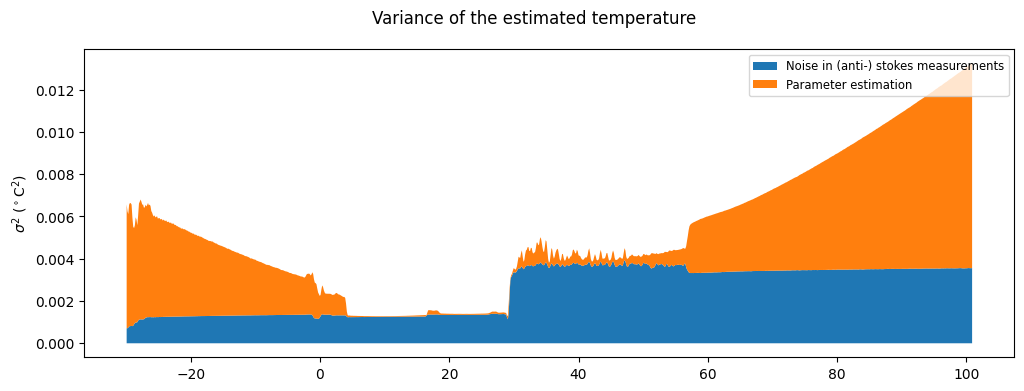

In [41]:
ds1 = ds.isel(time=0)

# Uncertainty from the noise in (anti-) stokes measurements
stast_var = ds1.var_fw_da.sel(comp_fw=['dT_dst', "dT_dast"]).sum(dim="comp_fw")

# Parameter uncertainty
par_var = ds1.tmpf_var - stast_var

# Plot
plt.figure(figsize=(12, 4))
plt.fill_between(ds1.x, stast_var, label="Noise in (anti-) stokes measurements")
plt.fill_between(ds1.x, y1=ds1.tmpf_var, y2=stast_var, label="Parameter estimation");
plt.suptitle('Variance of the estimated temperature')
plt.ylabel('$\sigma^2$ ($^\circ$C$^2$)');
plt.legend(fontsize="small");

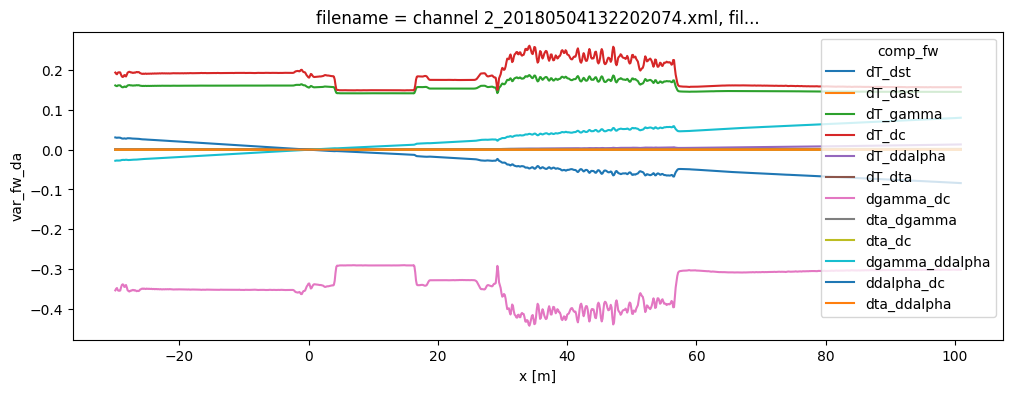

In [23]:
# The effects of the parameter uncertainty can be further inspected
ds1.var_fw_da.plot(hue="comp_fw", figsize=(12, 4));

## Monte Carlo estimate of the uncertainty
The uncertainty of the calibrated temperature can be computed in two manners:
1. The variance of the calibrated temperature can be approximated using linear error propagation
    - Very fast computation
    - Only the variance is estimated
    - Sufficiently accurate approximation for most cases
2. The uncertainty distribution of the calibrated temperature can be approximated using Monte Carlo
    - Slow computation
    - Computes variances and confidence intervals
    - Correctly propagates all uncertainties from the calibration
    - Requires sufficiently large number of samples to be drawn to be correct, hence the slow computation.
    - Only use this method: 1) To check the first method. 2) Specific interest in confidence intervals.
    
The first approach works very well and is used in the previous examples. **Here we show the second approach**.

The uncertainty comes from the noise in the (anti-) Stokes measurements and from the parameter estimation. Both sources are propagated via Monte Carlo sampling to an uncertainty distribution of the estimated temperature. As weigths are correctly passed to the least squares procedure via the `st_var` arguments, the covariance matrix can be used as an estimator for the uncertainty in the parameters. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix as part of the Monte Carlo routine, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated. The confidence intervals differ per time step. If you would like to calculate confidence intervals temporal averages or averages of fiber sections see notebook 16.

In [31]:
ds.conf_int_single_ended(
    st_var=st_var,
    ast_var=ast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500)

This function computes `ds.tmpf_mc_var` and `ds.tmpf_mc` if the keyword argument `conf_ints` is passed containing the confidence intervals. Increase the `mc_sample_size` for a 'less noisy' approximation.
### Monte Carlo estimation of the standard error

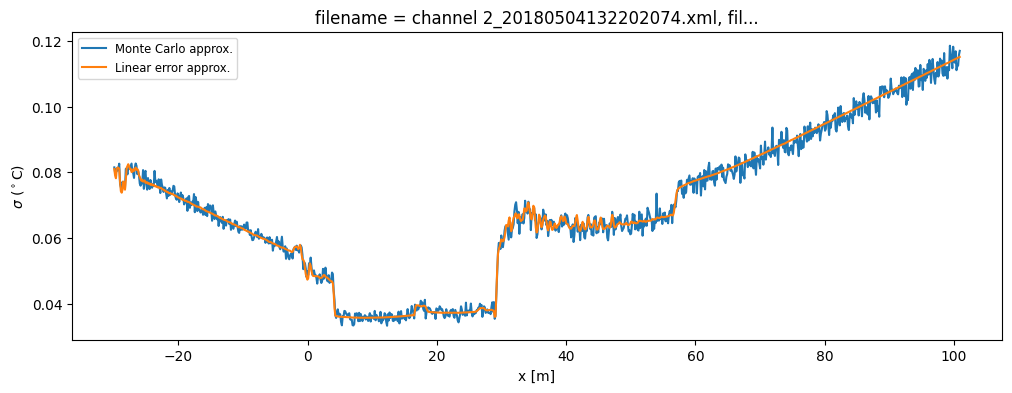

In [33]:
ds1 = ds.isel(time=0)

(ds1.tmpf_mc_var**0.5).plot(figsize=(12, 4), label="Monte Carlo approx.");
(ds1.tmpf_var**0.5).plot(label="Linear error approx.");
plt.ylabel('$\sigma$ ($^\circ$C)');
plt.legend(fontsize="small");

### Monte Carlo estimation of the confidence intervals

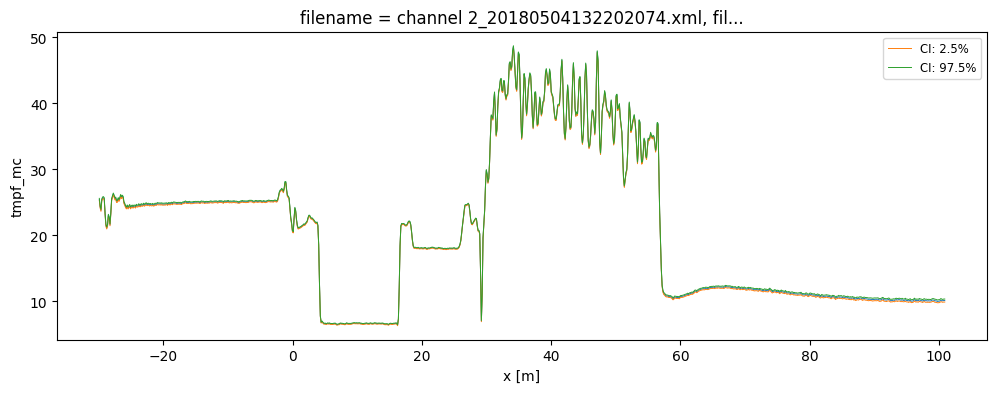

In [40]:
ds1.tmpf.plot(linewidth=0.7, figsize=(12, 4))
ds1.tmpf_mc.sel(CI=2.5).plot(linewidth=0.7, label='CI: 2.5%')
ds1.tmpf_mc.sel(CI=97.5).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend(fontsize="small");